In [2]:
import osmnx as ox
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from city_environment import visualize_city, generate_demand_matrix
# from route_evaluator import calculate_fitness
from optimized_route_evaluator import precompute_significant_trips, calculate_fitness

def create_real_city_graph():
    # 1. Download the map (Example: A neighborhood in Guadalajara)
    # You can use a bounding box or a name
    print("Downloading map data...")
    G_osm = ox.graph_from_place('Guadalajara, Mexico', network_type='drive')

    # 2. Keep the MultiDiGraph, osmnx functions are designed for it.
    # 3. Relabel nodes to Integers (0, 1, 2...) for matrix compatibility
    Y = G_osm # Use the graph from osmnx directly
    G = nx.convert_node_labels_to_integers(Y)

    # 4. Extract Positions (OSMnx stores them as 'x' and 'y' attributes)
    pos = {}
    for node, data in G.nodes(data=True):
        pos[node] = (data['x'], data['y'])
        
    # 5. Process Edges to set Weights
    # OSM data often includes 'length' (meters). We want 'time'.
    for u, v, key, data in G.edges(keys=True, data=True):
        length = data.get('length', 100) # Default 100m if missing
        
        # Heuristic: Assume "primary" roads are faster but have more traffic?
        # Or just use length as the base cost.
        # Speed estimate: 30 km/h = 500 m/min
        travel_time = length / 400
        
        # Add traffic noise
        G[u][v][key]['weight'] = travel_time * random.uniform(1.0, 1.5)
    
    with open(f"GA_output/sort_map.txt", "w") as text_file:
        text = str(Y)
        text_file.write(text)
        text_file.write("\n")
        text = str(G)
        text_file.write(text)
        text_file.write("\n")
        text = str(pos)
        text_file.write(text)
        text_file.write("\n")
        
    return G, pos

def visualize_city_gdl(G, pos, demand_matrix, hotspots=None):
    """
    Visualizes the city grid.
    - Edges are colored by Travel Time (Red = Slow, Gray = Fast)
    - Only hotspot nodes are shown.
    This version is optimized for large graphs from osmnx.
    """
    if hotspots is None:
        hotspots = []

    # Set node sizes: 50 for hotspots, 0 for all other nodes to hide them.
    node_sizes = [50 if node in hotspots else 0 for node in G.nodes()]
    # Set node colors: red for hotspots, white for others (though they won't be visible).
    node_colors = ['red' if node in hotspots else 'w' for node in G.nodes()]

    if not any(node_sizes):
        print("Warning: No hotspots to display. Showing only the street network.")
    else:
        print(f"Highlighting {len(hotspots)} hotspots.")

    edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

    # Use osmnx to plot the graph which handles large geo-data better
    fig, ax = ox.plot_graph(
        G,
        node_size=node_sizes,
        node_color='w',
        node_edgecolor='r',
        node_zorder=2,
        edge_linewidth=0.5,
        edge_color='k',
        bgcolor='#DDDDDD',
        show=False,  # Do not show or close the plot until we are done modifying it
        close=False
    )
    
    # Add a colorbar for the edge weights (travel time)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label('Street Travel Time (Minutes)')

    # Save the figure
    fig.savefig('city_visualization.png', dpi=300, bbox_inches='tight', pad_inches=0)
    print("City visualization saved to city_visualization.png")

# 1. Setup City
G, pos = create_real_city_graph()
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"City created with {num_nodes} stops and {num_edges} streets.")

City created with 22282 stops and 50192 streets.


Demand Matrix Generated. Total trips in simulation: 496444391
Highlighting 5 hotspots.
City visualization saved to city_visualization.png


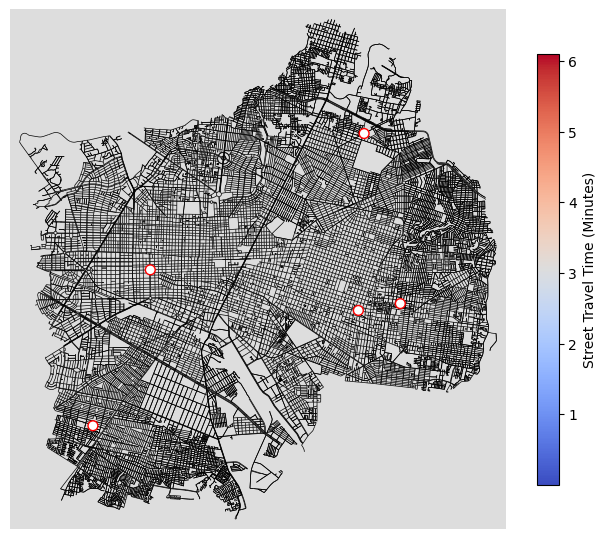

In [6]:
# 2. Generate Demand
hotspots = [35, 545, 22, 90, 22100]
demand = generate_demand_matrix(num_nodes, hotspots)
print(f"Demand Matrix Generated. Total trips in simulation: {np.sum(demand)}")

# 4. Show the Map
visualize_city_gdl(G, pos, demand, hotspots=hotspots)
